In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')
sys.path.insert(0, '../firmware')

In [2]:

import pandas
import seaborn
import numpy
np = numpy

from analysis import load_files

In [3]:

data = load_files('../data/one', fixup_shape=True)
print(data.shape)
data.head(5)

(1840, 23)


,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5034,5773,1670,7591,17984,1333,2034,2864,7309,...,5959,1795,1750,7589,17984,0,one_2500k_309lux.npy,one,309,2500
1,1571,5034,5773,1670,7592,17984,1333,2032,2862,7306,...,5961,1794,1750,7592,17980,1,one_2500k_309lux.npy,one,309,2500
2,1571,5037,5775,1670,7593,17984,1334,2032,2863,7307,...,5964,1796,1752,7595,17984,2,one_2500k_309lux.npy,one,309,2500
3,1572,5038,5773,1670,7596,17984,1333,2032,2862,7308,...,5963,1795,1750,7593,17981,3,one_2500k_309lux.npy,one,309,2500
4,1572,5040,5776,1671,7595,17982,1333,2035,2863,7307,...,5960,1795,1751,7592,17979,4,one_2500k_309lux.npy,one,309,2500


In [196]:
pandas.DataFrame(AS7343_INFO)

,channel,peak_wavelength_min,peak_wavelength,peak_wavelength_max,FWHM,counts,counts_min,counts_max
0,F1,395,405,415,30,5749,4311,7760
1,F2,415,425,435,22,1756,1317,2371
2,FZ,440,450,460,55,2169,1627,2711
3,F3,465,475,485,30,770,577,962
4,F4,505,515,525,40,3141,2356,3926
5,FY,545,555,565,100,3747,2810,4684
6,F5,540,550,560,35,1574,1180,1967
7,FXL,590,600,610,80,4776,3582,5970
8,F6,630,640,650,50,3336,2502,4170
9,F7,680,690,700,55,5435,4095,6774


In [197]:
from luxmeter_core import AS7343_INFO, photopic_interpolated

channels = pandas.DataFrame(AS7343_INFO).set_index('channel')
channels['sensitivity'] = 155e-3 / channels.counts # radiometric power (W/m²) per "count"
channels['feature'] = [f'ch_{c}' for c in channels.index]
channels['photopic_weight'] = channels.peak_wavelength.apply(photopic_interpolated)
channels['counts_min_rel'] = (100*(channels['counts_min']-channels['counts']) / channels['counts']).round(1)
channels['counts_max_rel'] = (100*(channels['counts_max']-channels['counts']) / channels['counts']).round(1)
channels['counts_range'] = (channels['counts_max']/channels['counts_min']).round(1)
channels

,peak_wavelength_min,peak_wavelength,peak_wavelength_max,FWHM,counts,counts_min,counts_max,sensitivity,feature,photopic_weight,counts_min_rel,counts_max_rel,counts_range
channel,,,,,,,,,,,,,
F1,395,405,415,30,5749,4311,7760,0.000027,ch_F1,0.000640,-25.0,35.0,1.8
F2,415,425,435,22,1756,1317,2371,0.000088,ch_F2,0.007300,-25.0,35.0,1.8
FZ,440,450,460,55,2169,1627,2711,0.000071,ch_FZ,0.038000,-25.0,25.0,1.7
F3,465,475,485,30,770,577,962,0.000201,ch_F3,0.112600,-25.1,24.9,1.7
F4,505,515,525,40,3141,2356,3926,0.000049,ch_F4,0.608200,-25.0,25.0,1.7
FY,545,555,565,100,3747,2810,4684,0.000041,ch_FY,1.000000,-25.0,25.0,1.7
F5,540,550,560,35,1574,1180,1967,0.000098,ch_F5,0.994950,-25.0,25.0,1.7
FXL,590,600,610,80,4776,3582,5970,0.000032,ch_FXL,0.631000,-25.0,25.0,1.7
F6,630,640,650,50,3336,2502,4170,0.000046,ch_F6,0.175000,-25.0,25.0,1.7


In [170]:
sampled = data.groupby('filename', group_keys=False).sample(frac=0.20)

numeric_cols = sampled.select_dtypes(include=['int16', 'float']).columns
sampled[numeric_cols] = sampled[numeric_cols].astype(float)

avg = sampled.groupby('filename').agg('median', numeric_only=True)
#avg = data.groupby('filename').agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,274.0,1206.5,1518.5,148.5,2132.5,17980.5,87.0,271.5,560.0,2060.0,...,17972.0,25.0,1537.0,208.0,265.0,2131.5,17982.0,7.5,100.0,2500.0
one_2500k_1lux.npy,5.0,11.0,10.0,16.0,19.0,588.0,3.0,5.0,8.0,13.0,...,588.0,1.0,13.0,9.0,3.0,19.0,588.5,11.0,1.0,2500.0
one_2500k_204lux.npy,738.0,2750.0,3312.0,614.5,4507.0,17978.0,458.0,858.0,1418.5,4352.5,...,17981.5,366.5,3378.0,720.0,777.0,4505.0,17982.0,17.5,204.0,2500.0
one_2500k_309lux.npy,1572.0,5038.0,5774.0,1670.0,7595.0,17982.0,1333.0,2033.0,2862.5,7306.5,...,17984.0,1264.0,5961.5,1795.0,1750.5,7592.0,17980.0,4.5,309.0,2500.0
one_2500k_408lux.npy,2432.0,7321.5,8191.5,2782.5,10594.0,17983.0,2266.5,3259.5,4331.0,10186.5,...,17982.0,2230.0,8516.0,2919.0,2761.0,10593.0,17984.0,7.0,408.0,2500.0


In [198]:
scaled = avg.copy()
c = channels.reset_index().set_index('feature')
scaled.loc[:, c.index] = scaled.loc[:, c.index] * c.sensitivity
scaled

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,0.000744,0.049909,0.031097,3.263042e-08,2132.5,17980.5,0.000056,0.006154,0.016807,0.016750,...,17972.0,4.313794e-07,0.000360,6.418148e-06,0.025964,2131.5,17982.0,7.5,100.0,2500.0
one_2500k_1lux.npy,0.000014,0.000455,0.000205,3.515736e-09,19.0,588.0,0.000002,0.000113,0.000240,0.000106,...,588.0,1.725517e-08,0.000003,2.777083e-07,0.000294,19.0,588.5,11.0,1.0,2500.0
one_2500k_204lux.npy,0.002004,0.113758,0.067825,1.350262e-07,4507.0,17978.0,0.000295,0.019448,0.042574,0.035390,...,17981.5,6.324021e-06,0.000791,2.221667e-05,0.076129,4505.0,17982.0,17.5,204.0,2500.0
one_2500k_309lux.npy,0.004269,0.208404,0.118242,3.669549e-07,7595.0,17982.0,0.000859,0.046080,0.085912,0.059409,...,17984.0,2.181054e-05,0.001396,5.538738e-05,0.171510,7592.0,17980.0,4.5,309.0,2500.0
one_2500k_408lux.npy,0.006604,0.302864,0.167749,6.114084e-07,10594.0,17983.0,0.001460,0.073881,0.129987,0.082826,...,17982.0,3.847904e-05,0.001994,9.007007e-05,0.270517,10593.0,17984.0,7.0,408.0,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rgb66_320h_253lux.npy,0.008864,0.075866,0.071500,2.966402e-08,3864.0,17983.5,0.000553,0.050897,0.006423,0.043334,...,17984.0,1.794538e-06,0.000043,2.530231e-06,0.009700,3863.5,17983.0,2.5,253.0,320.0
rgb66_340h_185lux.npy,0.004703,0.070137,0.070640,2.285228e-08,3157.0,17984.0,0.000307,0.026927,0.004112,0.043050,...,17984.0,1.138842e-06,0.000031,1.604537e-06,0.005781,3157.0,17984.0,7.5,185.0,340.0
rgb66_40h_280lux.npy,0.001111,0.139177,0.076036,5.207683e-08,3988.5,17983.5,0.000134,0.008523,0.121493,0.043651,...,17984.0,3.140442e-06,0.000066,5.523310e-06,0.055358,3987.5,17980.5,14.0,280.0,40.0


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.9996       0.9992       0.0004      
RMSE                      4.2345       6.3542       2.1197      
Mean Absolute Error       2.6208       4.7219       2.1011      
Sample Size               54           35          


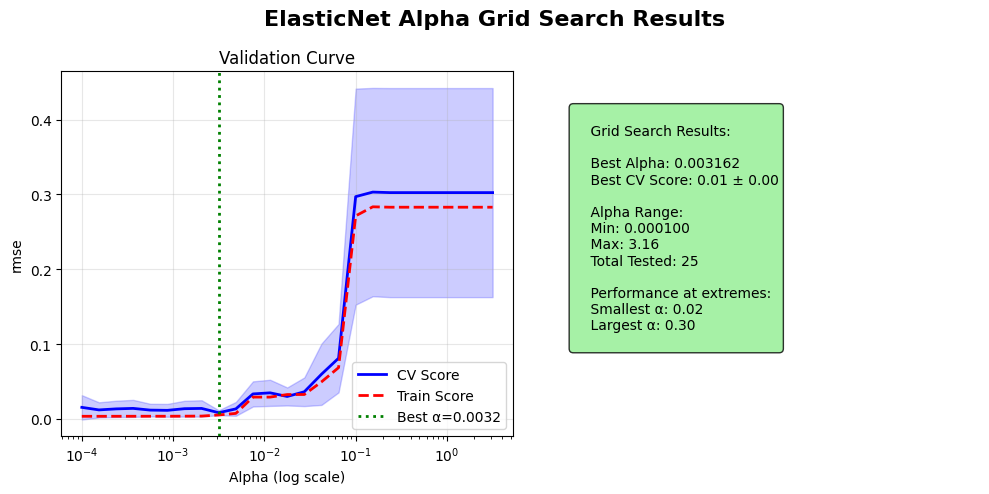

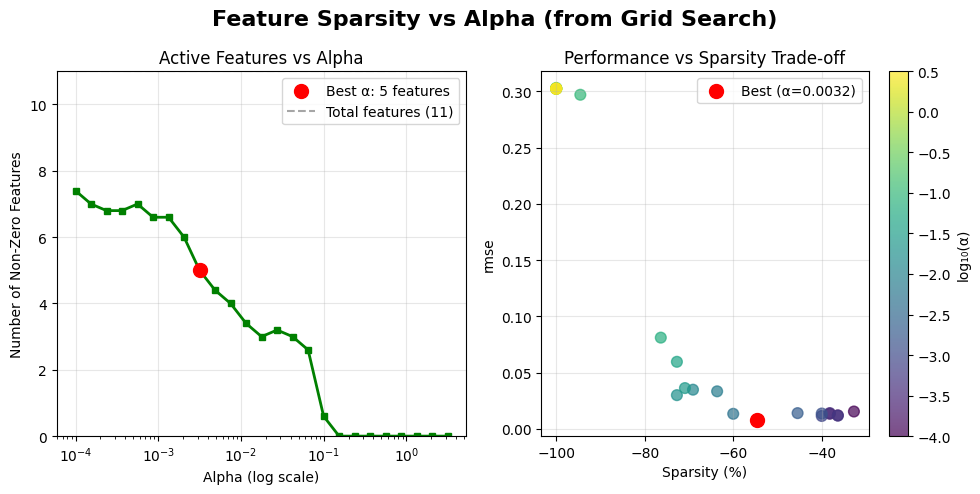

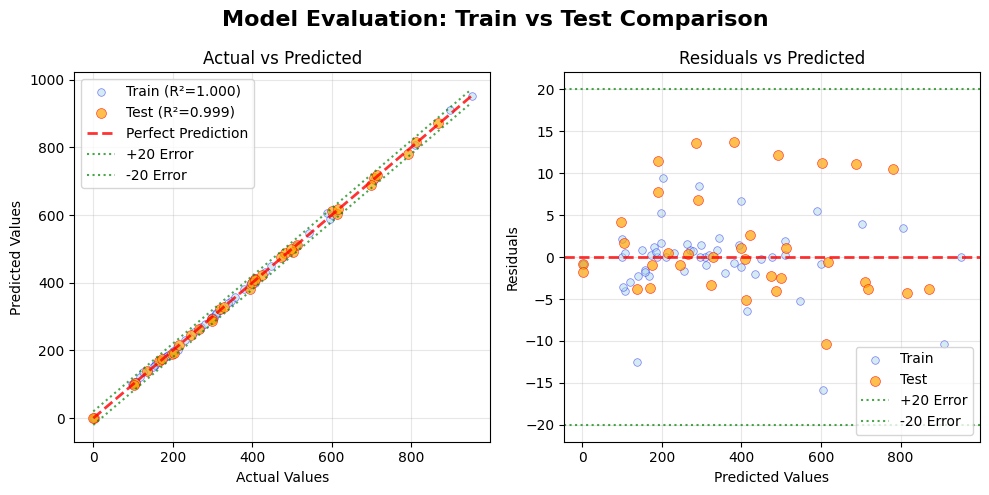

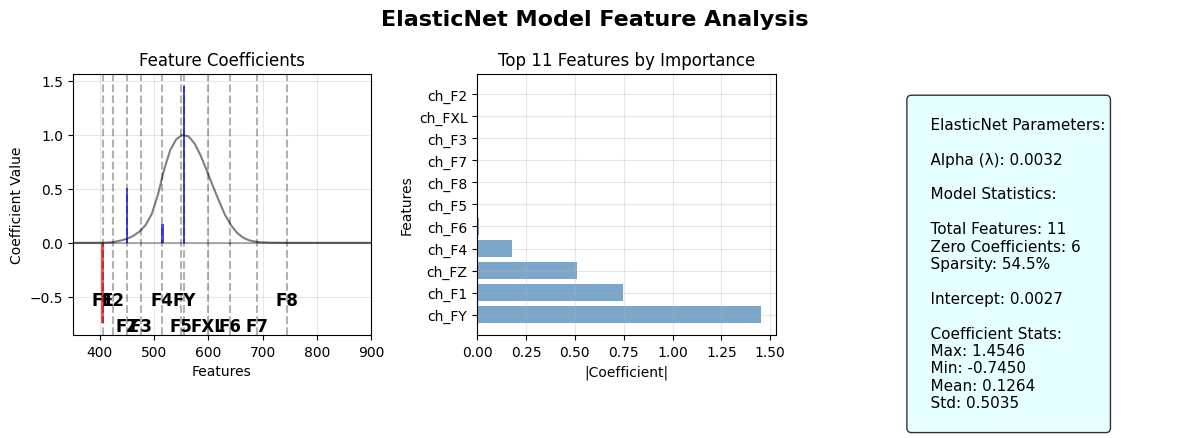

In [340]:
from train import create_pipeline, evaluate_pipeline, IdentityScaler

#sub = avg[avg.colortemp == 2500]
sub = scaled.copy()
sub = sub[sub.index != 'rgb1_280h_445lux.npy']
sub = sub[sub.index != 'rgb33_0h_55lux.npy']
#sub = sub[sub.index != 'one_2500k_589lux.npy']
sub = sub[sub.index != 'one_2500k_592lux.npy']


narrowband = list(set([c for c in sub.columns if c.startswith('ch_F')]) - set(['ch_FY'])) # avoid including both FY and F5, because overlapping
narrowband = list(set([c for c in sub.columns if c.startswith('ch_F')]) - set(['ch_F5'])) # avoid including both FY and F5, because overlapping

# Photopic luminous efficacy of radiation has a maximum possible value of 683.002 lm/W
PHOTOPIC_LUMINOUS_EFFICACY = 683.0
sub['energy_labeled'] = sub['lux'] / PHOTOPIC_LUMINOUS_EFFICACY
sub['energy_photopic'] = (sub[narrowband] * c.photopic_weight).sum(axis=1)

features = None
#features = list(set([c for c in sub.columns if c.startswith('ch_F')]) - set(['ch_FXL']))
#features = ['ch_F5', 'ch_F7', 'ch_F8']
#features = ['ch_FY']
#features = narrowband
#features = ['photopic_lux']

#features = narrowband + ['calc']

est = create_pipeline(positive=False, scaler=IdentityScaler, fit_intercept=True)
pipeline, features, predictions = evaluate_pipeline(est, sub, features=features, scale_predict=PHOTOPIC_LUMINOUS_EFFICACY, target='energy_labeled')
None

In [312]:
bad = predictions[predictions['error'].abs() > 20]
bad

,filename,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,...,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp,photopic_lux,split,out,error


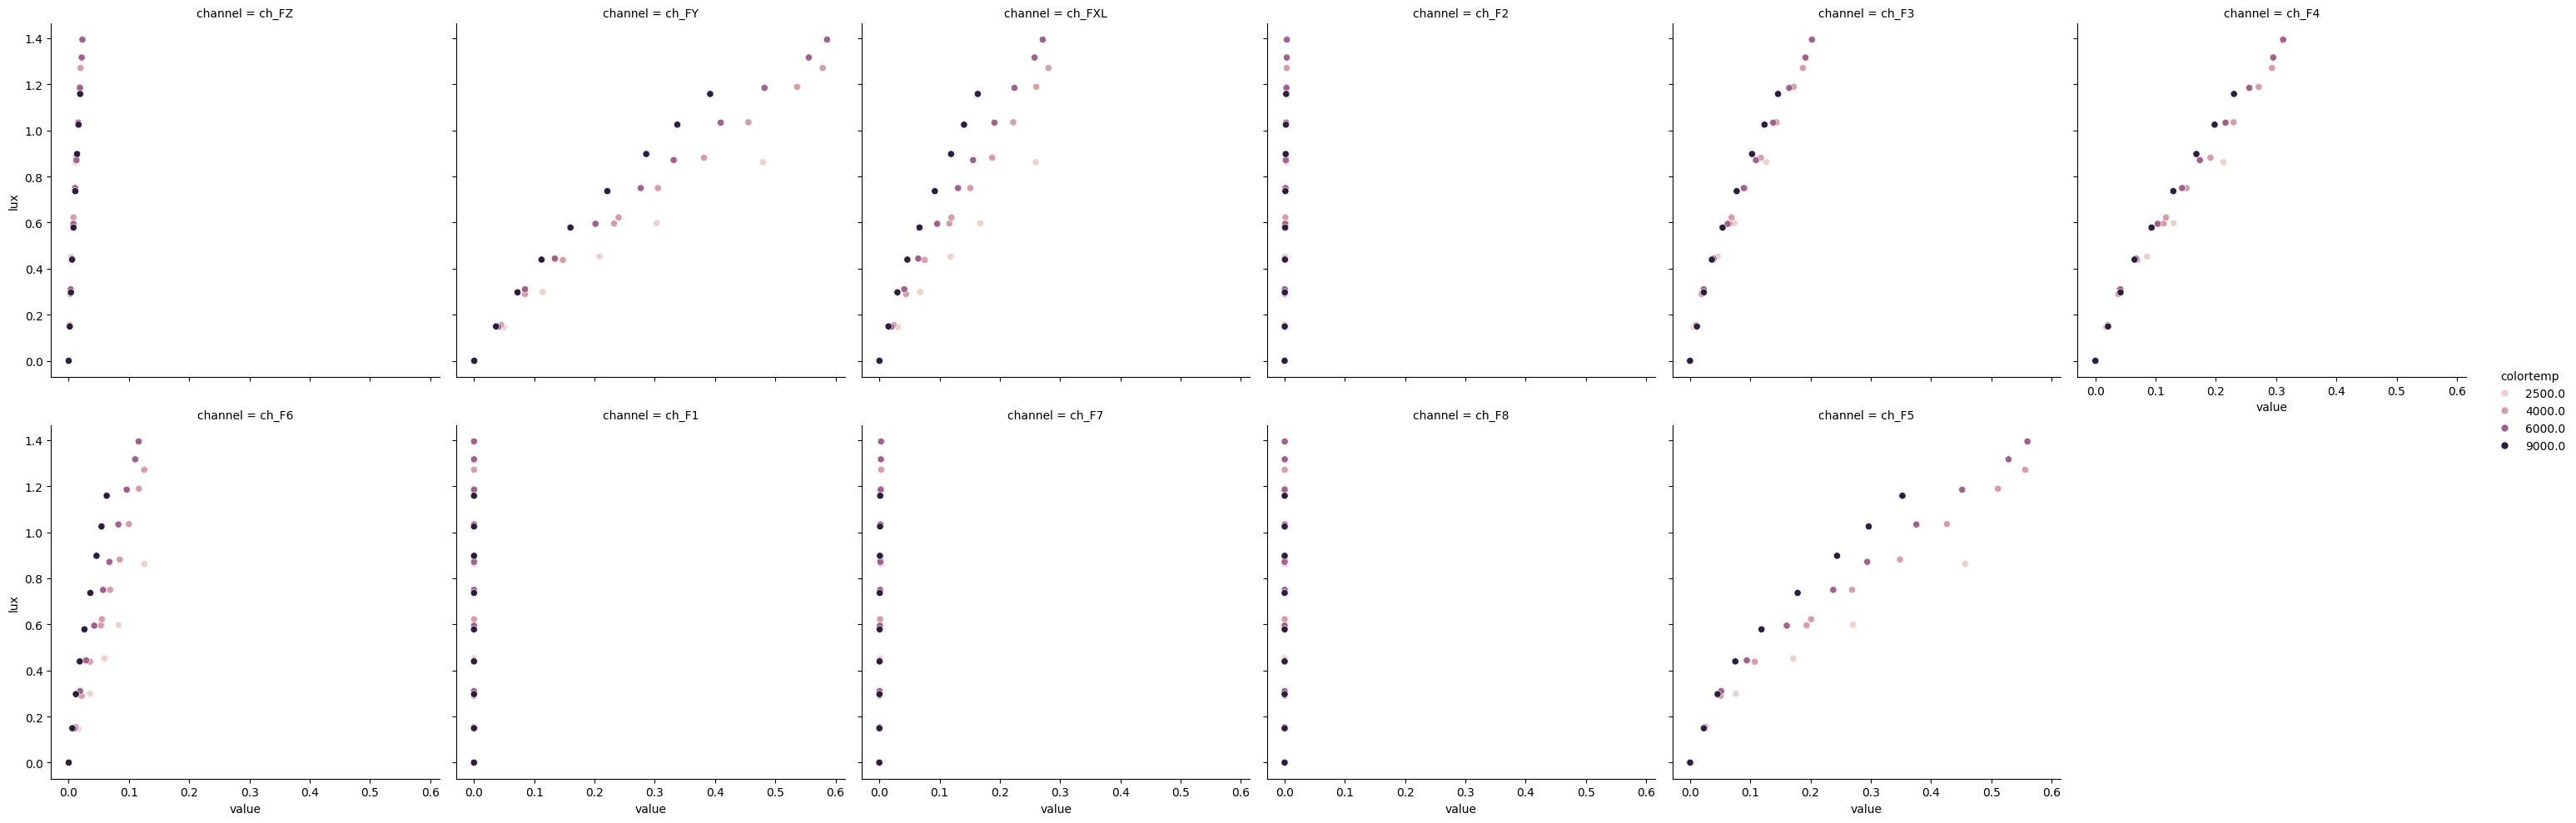

In [333]:

def plot_channels(df, hue='colortemp', target='lux', col_wrap=6):
    channels = [c for c in sub.columns if 'ch_F' in c ]
    #seaborn.pairplot(d, y_vars=conditions, x_vars=channels, col_wrap=col_wrap, hue=hue)
    # TODO: put channel order
    # TODO: put wavelength in plot names
    # TODO: colorize by rgb ?
    melted = pandas.melt(df.reset_index(), id_vars=['filename', 'colortemp', 'lux'], var_name='channel', value_vars=channels)    
    seaborn.relplot(data=melted, hue=hue, y=target, x='value', col='channel', col_wrap=col_wrap)

    #eaborn.pairplot(d, y='lux', x_vars=channels, col_wrap=col_wrap, hue=hue)

whites = predictions[predictions.colortemp > 1000]
plot_channels(whites)

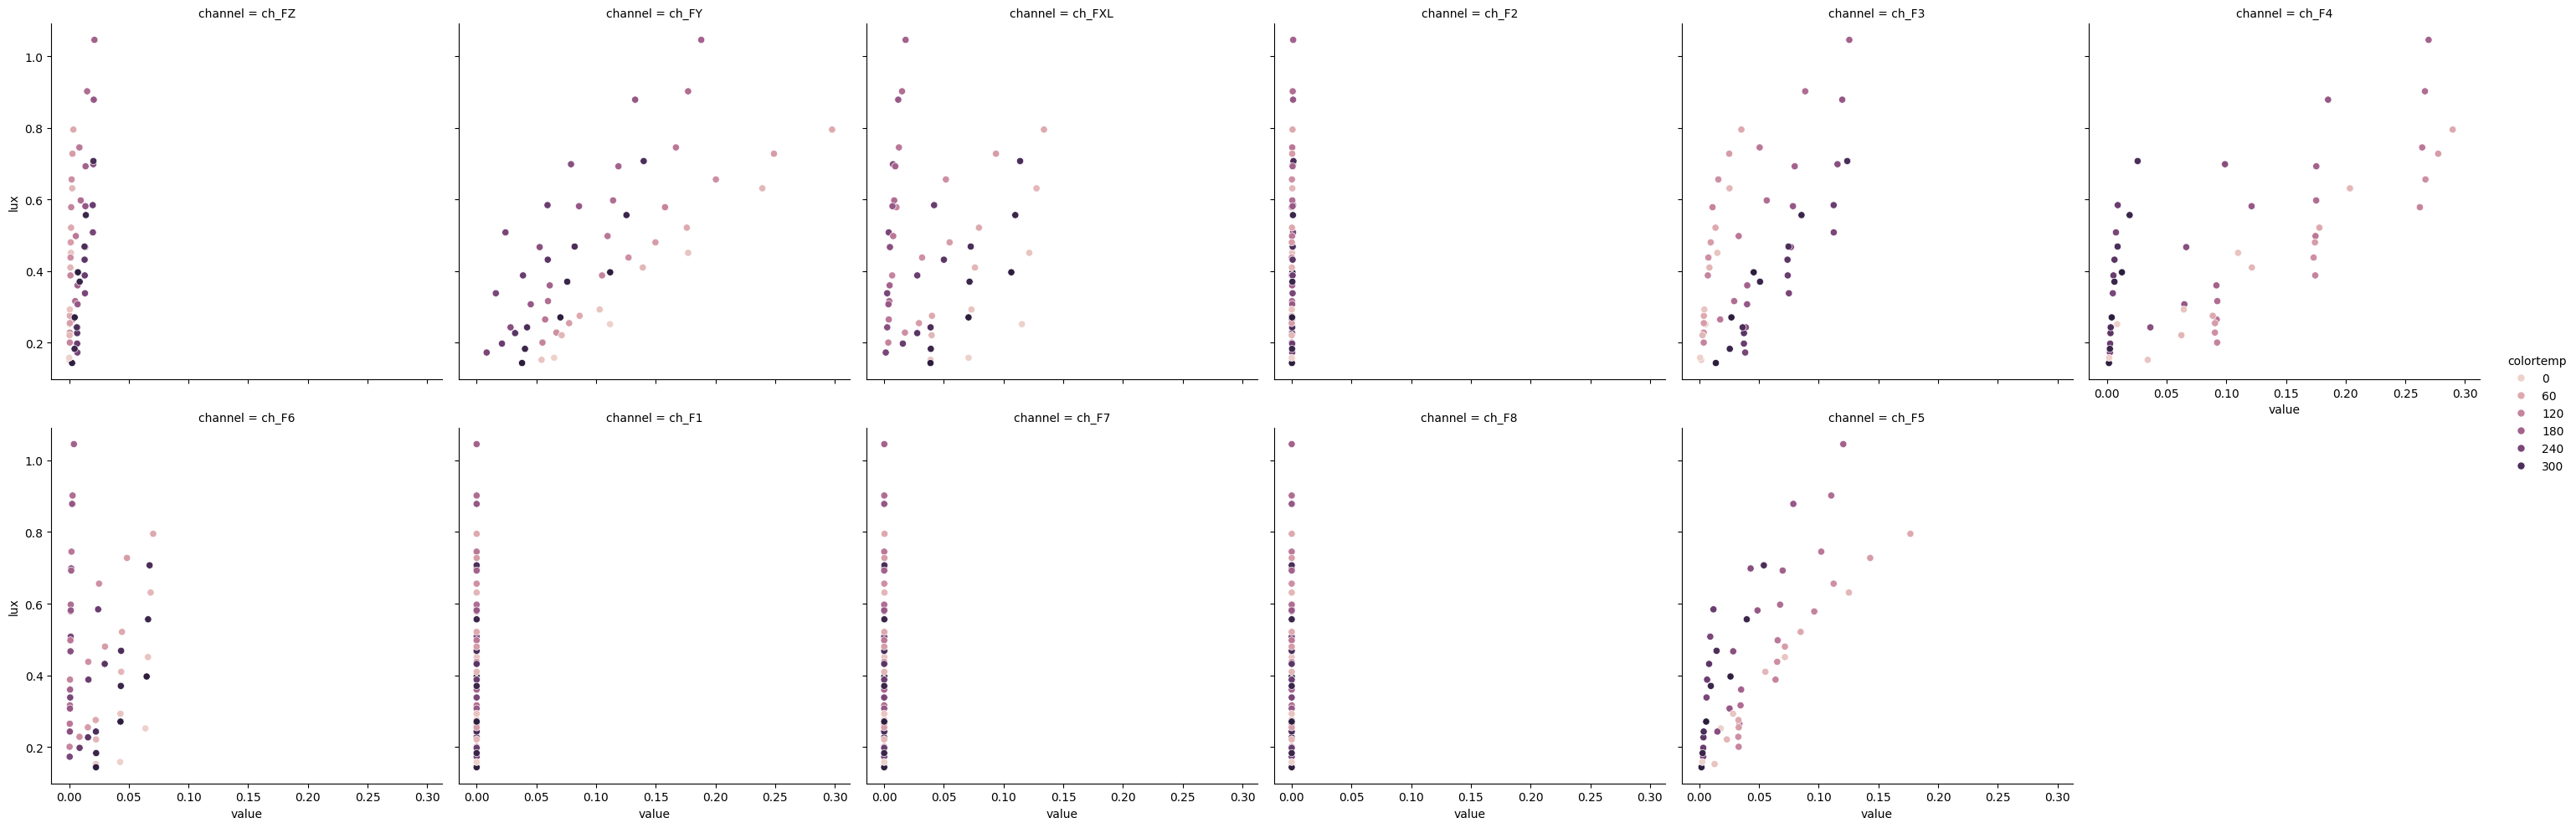

In [334]:
colors = predictions[predictions.colortemp < 1000]
plot_channels(colors)

In [336]:
#plot_channels(predictions, hue='error')

In [7]:
from luxmeter_core import AS7343_CHANNEL_MAP


def export_model(out, pipeline, features):

    scaler = pipeline.named_steps['scaler']
    regressor = pipeline.named_steps['regressor']
    assert len(pipeline.named_steps) == 2, pipeline.named_steps
    
    # We adapt the model to respect the original ordering/number of channels
    # Unused features will just be zeroed
    all_channels = AS7343_CHANNEL_MAP
    n_channels = len(all_channels)
    scale_min = numpy.zeros(n_channels)
    scale_mul = numpy.zeros(n_channels)
    regressor_weights = numpy.zeros(n_channels)
    
    for channel_idx, channel in enumerate(all_channels):
        feature = 'ch_'+channel
        if feature not in features:
            #print('Unused', channel, feature)
            continue
        feature_idx = features.index(feature)
        scale_min[channel_idx] = scaler.min_[feature_idx]
        scale_mul[channel_idx] = scaler.scale_[feature_idx]
        regressor_weights[channel_idx] = regressor.coef_[feature_idx]

    # Duplicate bias just to make it compatible in shape with the rest
    regressor_bias = numpy.array([regressor.intercept_] * n_channels)
    
    combined = numpy.stack([ scale_min, scale_mul, regressor_bias, regressor_weights ]).astype(float)
    print(combined)
    
    numpy.save(out, combined)

out_path = 'pipeline.npy'
export_model(out_path, pipeline, features)

[[-5.96836765e-04 -7.06688810e-04  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.43731202e-04 -4.32582082e-04
  -6.74796356e-04 -7.76372400e-04  0.00000000e+00  0.00000000e+00
  -2.19298246e-04 -9.05762917e-04 -1.53403643e-03 -5.25072197e-04
   0.00000000e+00  0.00000000e+00]
 [ 1.19367353e-04  7.06688810e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.71865601e-04  8.65164165e-05
   9.63994794e-05  6.46977000e-05  0.00000000e+00  0.00000000e+00
   2.19298246e-04  7.54802430e-05  1.91754554e-04  1.75024066e-04
   0.00000000e+00  0.00000000e+00]
 [ 4.16096996e+01  4.16096996e+01  4.16096996e+01  4.16096996e+01
   4.16096996e+01  4.16096996e+01  4.16096996e+01  4.16096996e+01
   4.16096996e+01  4.16096996e+01  4.16096996e+01  4.16096996e+01
   4.16096996e+01  4.16096996e+01  4.16096996e+01  4.16096996e+01
   4.16096996e+01  4.16096996e+01]
 [ 3.42134109e+02  1.13746929e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.

In [280]:
590/643

0.9175738724727839

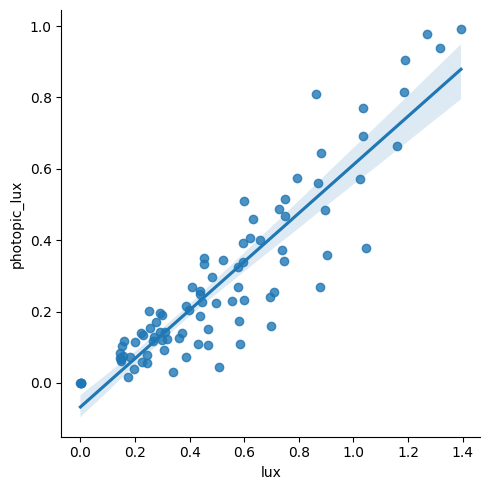

In [338]:
seaborn.lmplot(sub, x='lux', y='photopic_lux')

Hue 0.0°: RGB=[ 0.9  0.2  0.2]
Hue 45.0°: RGB=[ 0.9    0.725  0.2  ]
Hue 90.0°: RGB=[ 0.55  0.9   0.2 ]
Hue 135.0°: RGB=[ 0.2    0.9    0.375]
Hue 180.0°: RGB=[ 0.2  0.9  0.9]
Hue 225.0°: RGB=[ 0.2    0.375  0.9  ]
Hue 270.0°: RGB=[ 0.55  0.2   0.9 ]
Hue 315.0°: RGB=[ 0.9    0.2    0.725]


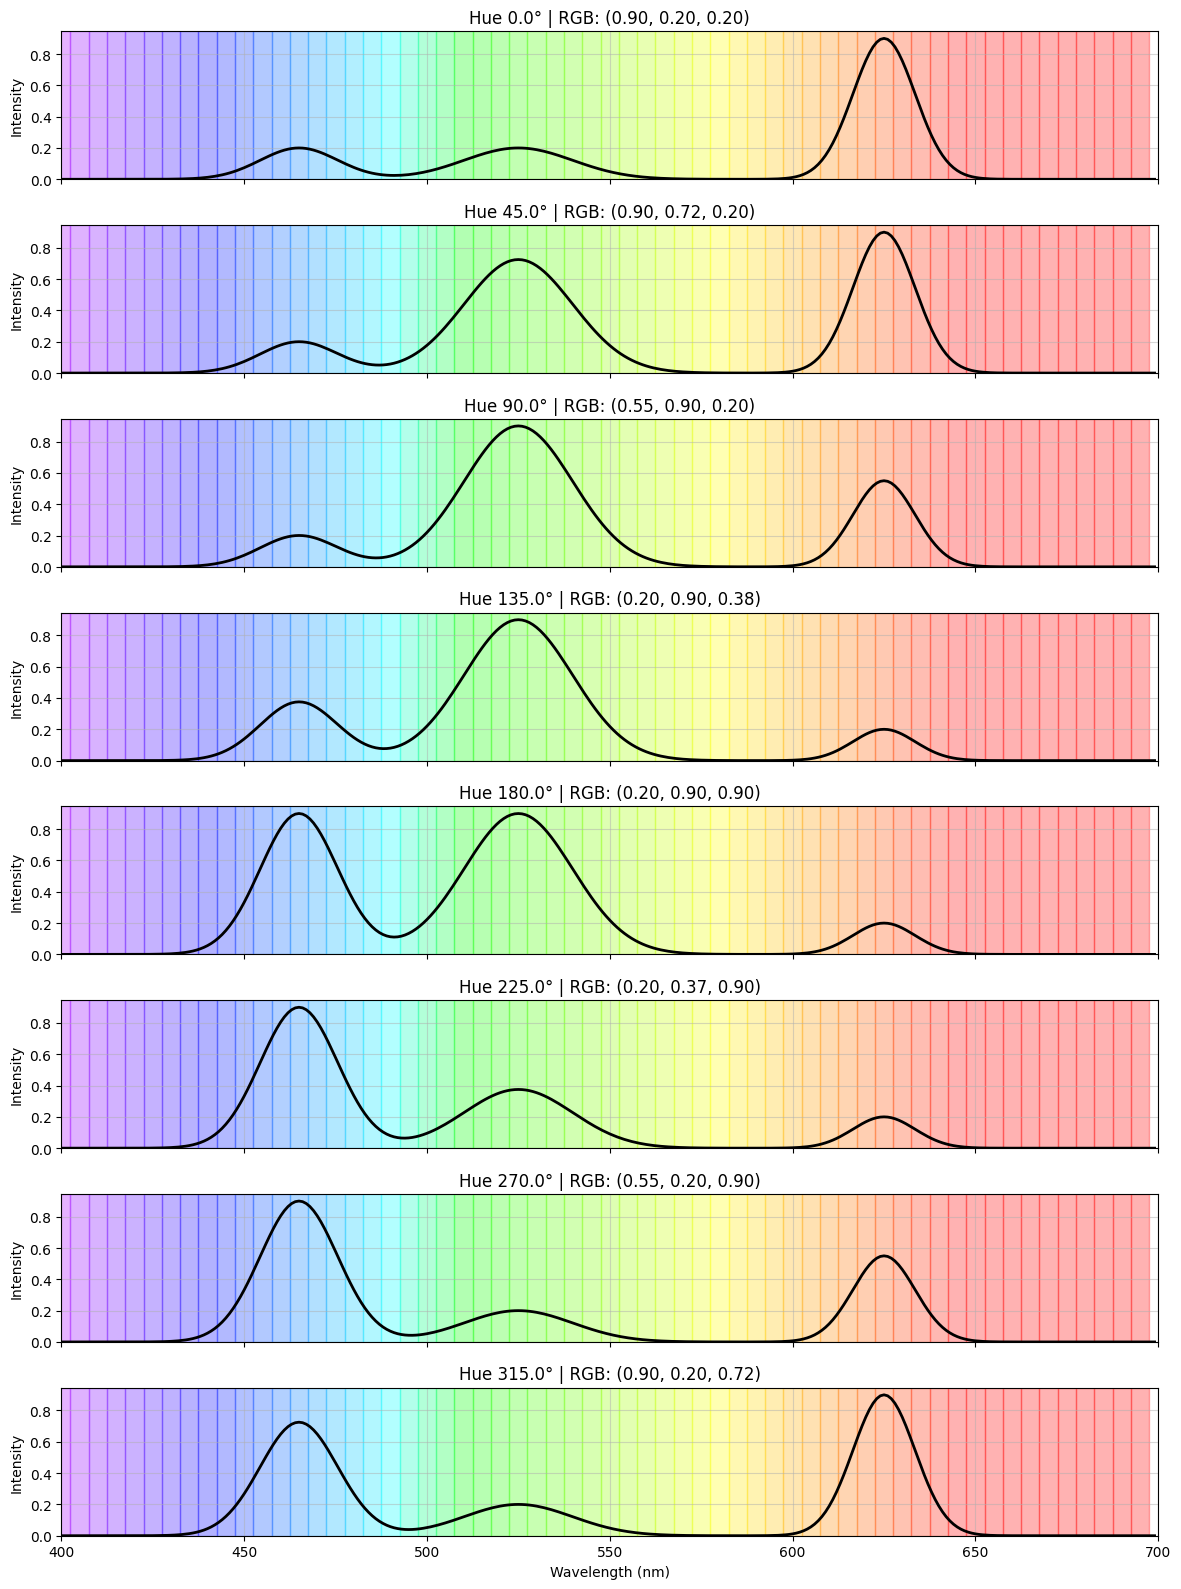

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import colour

def hue_to_spectrum_colour(hue, saturation=1.0):
    """Convert HSL hue to LED spectrum using manual HSL conversion"""
    # LED specifications
    leds = {
        'red': {'peak': 625, 'fwhm': 20},
        'green': {'peak': 525, 'fwhm': 35}, 
        'blue': {'peak': 465, 'fwhm': 25}
    }
    
    # Manual HSL to RGB conversion (the one that was working)
    h = (hue % 360) / 360
    def hue_to_rgb_component(p, q, t):
        if t < 0: t += 1
        if t > 1: t -= 1
        if t < 1/6: return p + (q - p) * 6 * t
        if t < 1/2: return q
        if t < 2/3: return p + (q - p) * (2/3 - t) * 6
        return p
    
    q = 0.5 + 0.5 * saturation
    p = 1 - saturation
    
    rgb = np.array([
        hue_to_rgb_component(p, q, h + 1/3),  # Red
        hue_to_rgb_component(p, q, h),        # Green  
        hue_to_rgb_component(p, q, h - 1/3)   # Blue
    ])
    
    print(f"Hue {hue}°: RGB={rgb}")  # Debug print
    
    # Create Gaussian LED spectra
    wavelengths = np.arange(400, 700, 1)
    spectrum_dict = {}
    
    led_colors = ['red', 'green', 'blue']
    for i, color in enumerate(led_colors):
        if rgb[i] > 0:
            # Gaussian spectrum for this LED
            peak = leds[color]['peak']
            fwhm = leds[color]['fwhm']
            sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
            
            led_spectrum = rgb[i] * np.exp(-0.5 * ((wavelengths - peak) / sigma) ** 2)
            
            # Add to spectrum dictionary
            for j, wl in enumerate(wavelengths):
                if led_spectrum[j] > 0:
                    spectrum_dict[wl] = spectrum_dict.get(wl, 0) + led_spectrum[j]
    
    # Create SpectralDistribution object
    sd = colour.SpectralDistribution(spectrum_dict, name=f'Hue {hue}°')
    
    return sd, rgb

def wavelength_to_rgb_colour(wavelength):
   """Simple wavelength to RGB conversion"""
   if 380 <= wavelength < 440:
       R = -(wavelength - 440) / (440 - 380)
       G = 0.0
       B = 1.0
   elif 440 <= wavelength < 490:
       R = 0.0
       G = (wavelength - 440) / (490 - 440)
       B = 1.0
   elif 490 <= wavelength < 510:
       R = 0.0
       G = 1.0
       B = -(wavelength - 510) / (510 - 490)
   elif 510 <= wavelength < 580:
       R = (wavelength - 510) / (580 - 510)
       G = 1.0
       B = 0.0
   elif 580 <= wavelength < 645:
       R = 1.0
       G = -(wavelength - 645) / (645 - 580)
       B = 0.0
   elif 645 <= wavelength <= 780:
       R = 1.0
       G = 0.0
       B = 0.0
   else:
       R = G = B = 0.0
   
   return (R, G, B)


def plot_hue_spectrum(ax, hue, saturation=1.0):
    """Plot spectrum for a given hue using colour-science objects"""
    sd, rgb_weights = hue_to_spectrum_colour(hue, saturation)
    
    # Get wavelengths and values from SpectralDistribution
    wavelengths = sd.wavelengths
    values = sd.values
    
    # Create wavelength color background
    wl_range = np.arange(400, 700, 5)
    for wl in wl_range:
        rgb = wavelength_to_rgb_colour(wl)
        ax.axvspan(wl-2.5, wl+2.5, color=rgb, alpha=0.3, zorder=0)
    
    # Plot spectrum
    ax.plot(wavelengths, values, 'k-', linewidth=2, zorder=2)
    ax.set_ylabel('Intensity')
    ax.set_title(f'Hue {hue}° | RGB: ({rgb_weights[0]:.2f}, {rgb_weights[1]:.2f}, {rgb_weights[2]:.2f})')
    ax.grid(True, alpha=0.5, zorder=1)
    ax.set_xlim(400, 700)
    ax.set_ylim(0, None)

# Plot multiple hues in single column
N = 8
hues = np.linspace(0, 360, N, endpoint=False)

fig, axes = plt.subplots(N, 1, figsize=(12, 2.0*N), sharex=True)

for i, hue in enumerate(hues):
    plot_hue_spectrum(axes[i], hue, saturation=0.8)

for ax in axes[:-1]:
    ax.set_xlabel('')
    
axes[-1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()

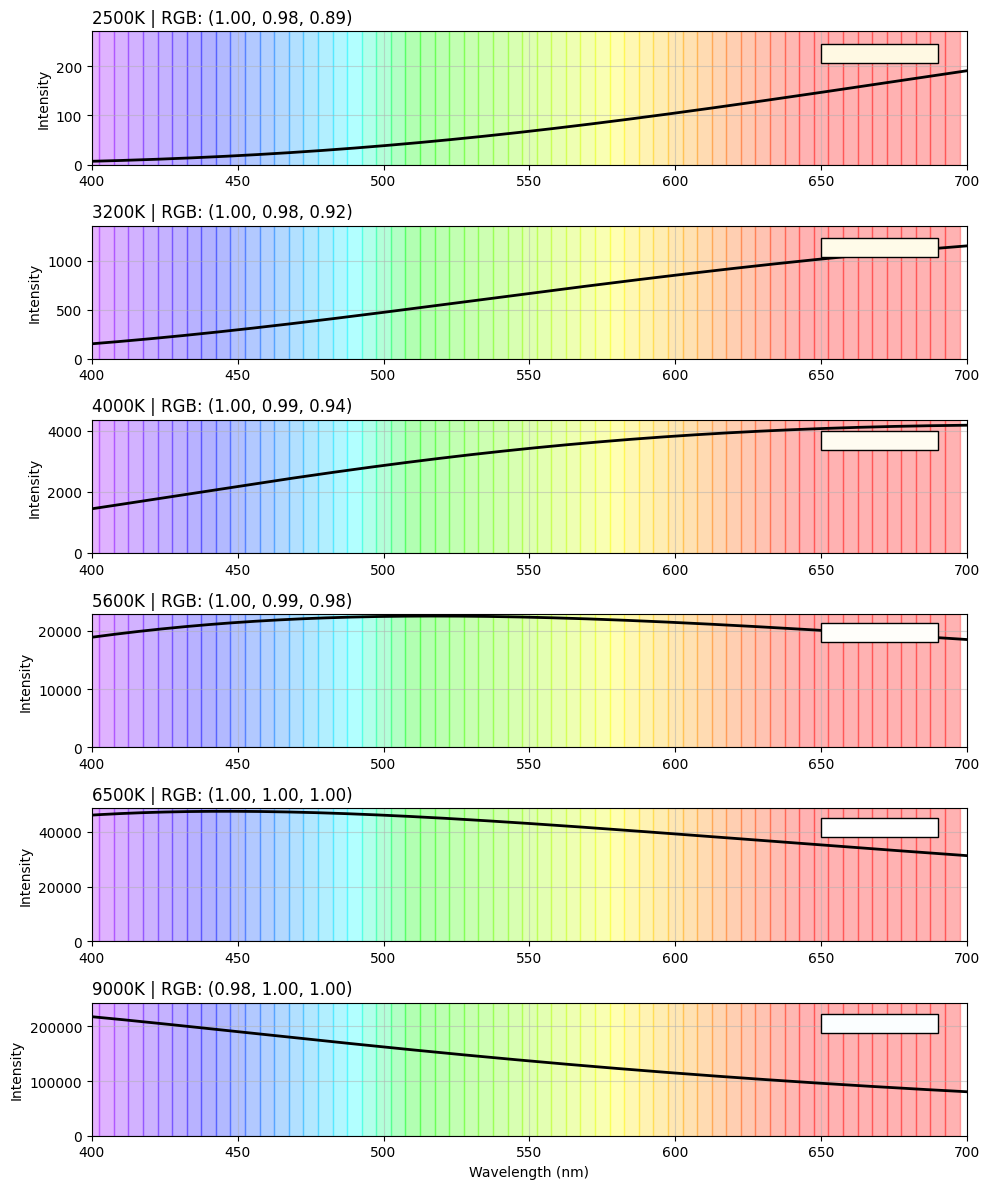

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import colour

def temp_to_rgb_colour(temp_k):
    """Convert color temperature to tinted white"""
    # Get the color temperature tint
    xy = colour.CCT_to_xy(temp_k)
    XYZ = colour.xy_to_XYZ(xy) * 95
    RGB = colour.XYZ_to_sRGB(XYZ / 100)
    RGB = np.clip(RGB, 0, 1)
    
    # Mix with white to create tinted white
    white = np.array([1.0, 1.0, 1.0])
    tint_strength = 0.2  # How much tint vs pure white
    
    tinted_white = (1 - tint_strength) * white + tint_strength * RGB
    
    return tinted_white

def plot_temp_spectrum(ax, temp_k):
   """Plot blackbody spectrum for given temperature with RGB color patch"""
   # Get blackbody spectral distribution
   sd = colour.sd_blackbody(temp_k, colour.SpectralShape(360, 780, 1))
   wavelengths = sd.wavelengths
   values = sd.values
   
   # Get RGB color for this temperature
   rgb = temp_to_rgb_colour(temp_k)
   
   # Create wavelength color background
   wl_range = np.arange(400, 700, 5)
   for wl in wl_range:
       wl_rgb = wavelength_to_rgb_colour(wl)
       ax.axvspan(wl-2.5, wl+2.5, color=wl_rgb, alpha=0.3, zorder=0)
   
   # Plot spectrum
   ax.plot(wavelengths, values, 'k-', linewidth=2, zorder=2)
   
   # Add RGB color rectangle in top-right corner
   from matplotlib.patches import Rectangle
   rect = Rectangle((650, 0.8 * np.max(values)), 40, 0.15 * np.max(values), 
                    facecolor=rgb, edgecolor='black', linewidth=1, zorder=3)
   ax.add_patch(rect)
   
   ax.set_ylabel('Intensity')
   ax.set_title(f'{temp_k}K | RGB: ({rgb[0]:.2f}, {rgb[1]:.2f}, {rgb[2]:.2f})', loc='left')
   ax.grid(True, alpha=0.5, zorder=1)
   ax.set_xlim(400, 700)
   ax.set_ylim(0, None)

# Plot different color temperatures
temps = [2500, 3200, 4000, 5600, 6500, 9000]  # Kelvin

fig, axes = plt.subplots(len(temps), 1, figsize=(10, 2.0*len(temps)))

for i, temp in enumerate(temps):
   plot_temp_spectrum(axes[i], temp)

# Only show x-axis label on bottom plot
for ax in axes[:-1]:
   ax.set_xlabel('')
   
axes[-1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()